In [29]:
def make_k_circles(k=2,n_samples=100, shuffle=True, noise=None, random_state=None,
                 factor=.8, c=None, rot=None):
    """Make a large circle containing a smaller circle in 2d.
    A simple toy dataset to visualize clustering and classification
    algorithms.
    Read more in the :ref:`User Guide <sample_generators>`.
    Parameters
    ----------
    n_samples : int or two-element tuple, optional (default=100)
        If int, it is the total number of points generated.
        For odd numbers, the inner circle will have one point more than the
        outer circle.
        If two-element tuple, number of points in outer circle and inner
        circle.
    shuffle : bool, optional (default=True)
        Whether to shuffle the samples.
    noise : double or None (default=None)
        Standard deviation of Gaussian noise added to the data.
    random_state : int, RandomState instance, default=None
        Determines random number generation for dataset shuffling and noise.
        Pass an int for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.
    factor : 0 < double < 1 (default=.8)
        Scale factor between inner and outer circle.
    Returns
    -------
    X : array of shape [n_samples, 2]
        The generated samples.
    y : array of shape [n_samples]
        The integer labels (0 or 1) for class membership of each sample.
    """

    if not factor is None and (factor >= 1 or factor < 0):
        raise ValueError("'factor' has to be between 0 and 1.")
    if factor is None and c is None:
        raise ValueError("one of 'factor' or 'c' has to be between 0 and 1.")
    if isinstance(n_samples, numbers.Integral):
        n_samples_lists = [n_samples//k for i in range(k-1)]
        n_samples_lists.append(n_samples-np.sum(n_samples_lists))
#         n_samples_out = n_samples // 2
#         n_samples_in = n_samples - n_samples_out
    else:
        try:
            n_samples_lists = n_samples
            assert(len(n_samples)==k)
#             n_samples_out, n_samples_in = n_samples
        except ValueError:
            raise ValueError('`n_samples_lists` can be either an int or '
                             'a k-element tuple.')

    generator = check_random_state(random_state)
    # so as not to have the first point = last point, we set endpoint=False
    linspaces=[np.linspace(0, 2 * np.pi, n_samples_list, endpoint=False) for n_samples_list in n_samples_lists]
    if rot is not None:
        linspaces=[np.linspace(0+r, r+2 * np.pi, n_samples_list, endpoint=False) for n_samples_list,r in zip(n_samples_lists,rot)]
#     linspace_out = np.linspace(0, 2 * np.pi, n_samples_out, endpoint=False)
#     linspace_in = np.linspace(0, 2 * np.pi, n_samples_in, endpoint=False)
    if factor:
        circs_x = [np.cos(linspace)*factor**i for i,linspace in enumerate(linspaces)]
        circs_y = [np.sin(linspace)*factor**i for i,linspace in enumerate(linspaces)]
    else: 
        circs_x = [np.cos(linspace)*c*i for i,linspace in enumerate(linspaces)]
        circs_y = [np.sin(linspace)*c*i for i,linspace in enumerate(linspaces)]
#     outer_circ_x = np.cos(linspace_out)
#     outer_circ_y = np.sin(linspace_out)
#     inner_circ_x = np.cos(linspace_in) * factor
#     inner_circ_y = np.sin(linspace_in) * factor
    X = np.vstack([np.concatenate(circs_x, axis=0),
                   np.concatenate(circs_y, axis=0)]).T
    y = np.hstack([np.ones(n_samples_list, dtype=np.intp)*i for i,n_samples_list in enumerate(n_samples_lists)])
#     X = np.vstack([np.append(outer_circ_x, inner_circ_x),
#                    np.append(outer_circ_y, inner_circ_y)]).T
#     y = np.hstack([np.zeros(n_samples_out, dtype=np.intp),
#                    np.ones(n_samples_in, dtype=np.intp)])
    if shuffle:
        X, y = util_shuffle(X, y, random_state=generator)

    if noise is not None:
        X += generator.normal(scale=noise, size=X.shape)

    return X, y
def get_rotation(a,b):
    g = np.gcd(a,b)
    diff1 = (b/2)%g
    diff2 = (a/2)%g
    shift1 = min(diff1, g-diff1)
    shift2 = min(diff2, g-diff2)
    rot=(np.abs(shift2-shift1)/2)*2*np.pi/(a*b)
    min_rot_dist = ((shift1+shift2)/2)*2*np.pi/(a*b)
    return rot, min_rot_dist
def get_rotations(n_samples):
    rots=[0,0]
    min_rot_dists=[]
    for i in range(1,len(n_samples)-1):
        rot,min_rot_dist = get_rotation(n_samples[i],n_samples[i+1])
        rots.append(rot)
        min_rot_dists.append(min_rot_dist)
    return rots, min_rot_dists
        

def get_cmap(n, name='tab20'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
    

[0, 0, 0.2617993877991494, 0.1308996938995747]
[0.2617993877991494, 0.1308996938995747]
[0, 0, 0.2617993877991494, 0.39269908169872414]
[(0, 1), (1, 3), (2, 6), (3, 12)]


<IPython.core.display.Javascript object>


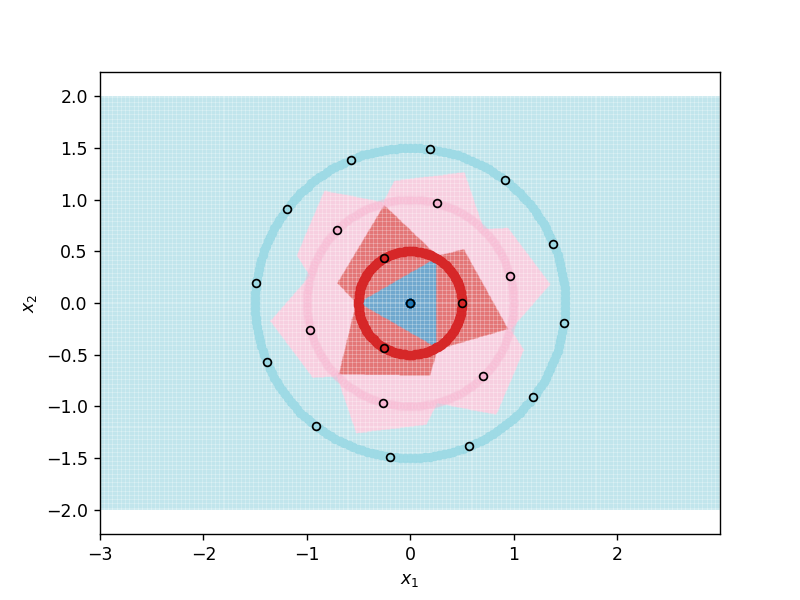

In [119]:
%matplotlib notebook

from sklearn.utils import check_random_state, shuffle as util_shuffle
import numbers
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from imblearn.under_sampling import *
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier as kNC
import numpy as np
num_classes=4
growth=0.5
X, y = make_k_circles(k=num_classes,n_samples=800,factor=None, c=growth, noise=.0)
#cnn = ClusterCentroids(sampling_strategy='all')#,random_state=0)
#n_samples=[1,3,6,9,12]
n_samples=[1,4,7,10]#,13,16]
n_samples=[1,3,6,12]#,13,16]
rot,min_rot_dist = get_rotations(n_samples)
print(rot)
print(min_rot_dist)
#rot=[0,0,np.pi/6,np.pi/12,0,0]
#rot=[0,0,0,0,0,0]
for i in range(2,num_classes):
    rot[i]+=rot[i-1]#-(2*np.pi/(2*n_samples[i]))+(2*np.pi*np.gcd(n_samples[i-1],n_samples[i])/(2*n_samples[i-1]*n_samples[i]))
print(rot)
#print([0,0,2*np.pi/(4*6),1.5*np.pi/(6*9),2*1.5*np.pi/(9*12)])
#rot=[0,0,2*np.pi/(2*6)+2*np.pi/(4*6),2*np.pi/(2*6)+1.5*np.pi/(6*9),1.5*np.pi/(9*12)]
X_resampled, y_resampled = make_k_circles(k=num_classes, n_samples=n_samples, factor=None, c=growth, noise=0, rot =rot)#cnn.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))
#plt.title("Original space")
classes = [y==i for i in range(num_classes)]
# reds = y == 0
# blues = y == 1
# greens = y == 2
classes_resampled = [y_resampled==i for i in range(num_classes)]
# reds_resampled = y_resampled == 0
# blues_resampled = y_resampled == 1
# greens_resampled = y_resampled == 2

#plt.show()
distX=X_resampled
distY=y_resampled
clf=kNC(n_neighbors=1, weights="distance") #Can mess around with n_neighbors and weighting type, e.g. sum(n_samples)
clf.fit(distX,distY)
    #print(distX)
    #print(distY)

# Create color maps
if num_classes>20:
    cmap="gist_ncar"
else:
    cmap="tab20"
cmap_single = get_cmap(num_classes, cmap)
colors=cmap_single(range(num_classes))
#print(colors)
# create KNN classifier
# clf = SoftKNN(k=k)
#clf = neighbors.KNeighborsClassifier(min(n_neighbors, len(distX)), weights=weights)
# clf.fit(distX, distY)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
rad=num_classes*growth
x_min, x_max = -rad-1,rad+1
y_min, y_max = -rad,rad
size = (x_max-x_min)*(y_max-y_min)
desired_particles = 800000
h = (size/desired_particles)**0.5  # step size in the mesh

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
# ax1.clear()
plt.pcolormesh(xx, yy, Z, cmap=cmap_single, alpha=0.1)
# if not mode =="true": 
#     ax1.scatter(distX[:, 0], distX[:, 1], c="black")
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#plt.title("3-Class classification (k = %i)")
# for i in range(num_points):
#     axs[i].pie(dy[i], colors=colors)
for i in range(num_classes):
    plt.scatter(X[classes[i], 0], X[classes[i], 1], c=[colors[i]],
            s=20, alpha=1 if i != 2 else 0.2)#edgecolor='k')
    plt.scatter(X_resampled[classes_resampled[i], 0], X_resampled[classes_resampled[i], 1], c=[colors[i]],
            s=20,edgecolor='k')
# plt.scatter(X[reds, 0], X[reds, 1], c=[colors[0]],
#             s=20,alpha=0.2)# edgecolor='k')
# # km = KMeans(n_clusters=8)
# # km.fit(X[reds])
# # centers_red=km.cluster_centers_
# # plt.scatter(centers_red[:,0],centers_red[:,1],c="black")
# plt.scatter(X_resampled[reds_resampled, 0], X_resampled[reds_resampled, 1], c=[colors[0]],
#             s=20,edgecolor='k')

# plt.scatter(X[blues, 0], X[blues, 1], c=[colors[1]],
#             s=20, alpha=0.2)#edgecolor='k')
# plt.scatter(X_resampled[blues_resampled, 0], X_resampled[blues_resampled, 1], c=[colors[1]],
#             s=20,edgecolor='k')

# plt.scatter(X[greens, 0], X[greens, 1], c=[colors[2]],
#             s=20, alpha=0.2)#edgecolor='k')# km = KMeans(n_clusters=8)
# plt.scatter(X_resampled[greens_resampled, 0], X_resampled[greens_resampled, 1], c=[colors[2]],
#             s=20,edgecolor='k')
# km.fit(X[blues])
# centers_blue=km.cluster_centers_
# plt.scatter(centers_blue[:,0],centers_blue[:,1],c="black")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.axis('equal')

plt.savefig("knn_and_4_circles_opt.png")
plt.show()

100%|██████████| 8/8 [00:00<00:00, 11594.48it/s]

N: 2 M: 1 Valid: False


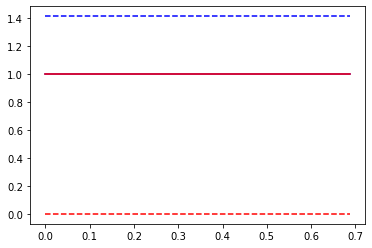

100%|██████████| 12/12 [00:00<00:00, 8440.66it/s]


N: 3 M: 1 Valid: True


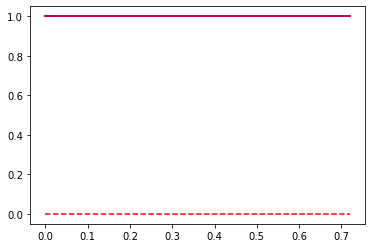

3


[1, 4, 7, 10, 13, 16, 19, 22, 26, 29, 32, 35, 38, 41]

In [1]:
#%matplotlib notebook
from tqdm import tqdm
import numpy as np
from numpy import sqrt as sqrt
import matplotlib.pyplot as plt
def d1(t,c,m,n,theta):
    dists = []
    for i in range(m):
        for j in range(n):
            dist = sqrt((t*c)**2 +((t+1)*c)**2 -2*t*(t+1)*(c**2)*np.cos((i*2*np.pi/m) - (j*2*np.pi/n) -np.pi/n - theta))
            dists.append(dist)
    return np.min(dists)
def d2(t,c,m,n,theta):
    dists = []
    for i in range(m):
        for j in range(n):
            dist = sqrt((t*c)**2 +((t+1)*c)**2 -2*t*(t+1)*(c**2)*np.cos((i*2*np.pi/m) - (j*2*np.pi/n) +np.pi/m - theta))
            dists.append(dist)
    return np.min(dists)


def check_configuration(m,n,t):
    db = sqrt(2*((t+1)*c)**2 - (2*((t+1)*c)**2)*np.cos(np.pi/n))
    #print(db)
    da = sqrt(2*(t*c)**2 - (2*(t*c)**2)*np.cos(np.pi/m))
    thetas = [i*np.pi/(m*n*16) for i in range(m*n*4)]
    bools = []
    d1s=[]
    d2s=[]
    for theta in tqdm(thetas):
            d1_temp=d1(t,c,m,n,theta)
            d2_temp=d2(t,c,m,n,theta)
            valid = d1_temp> db and d2_temp> da
            bools.append(valid)
            d1s.append(d1_temp)
            d2s.append(d2_temp)

        #valid_reg = np.array(thetas)[bools]
        #print (valid_reg)
    print ("N: {0} M: {1} Valid: {2}".format(n,m,np.any(bools)))
    #print(np.where(bools))
    plt.plot(thetas,d1s, "b")
    plt.plot([thetas[0],thetas[-1]],[db,db], "b--")
    plt.plot(thetas,d2s, "r")
    plt.plot([thetas[0],thetas[-1]],[da,da], "r--")
    plt.show()
    return np.any(bools)
def find_smallest_n(m,t, max_iters=100):
    for n in range(m+1,m+max_iters):
        if check_configuration(m,n,t):
            return n
    print("Failed to find valid N!")
    return -1
m=1
n= 5
t=0
c=1     
print(find_smallest_n(m,t))
    
[1,3,6,12,13,16,19,22,26,29,32,35,38,41]#Empirical method
[1,4,7,10,13,16,19,22,26,29,32,35,38,41]#Guaranteed method
    

<IPython.core.display.Javascript object>


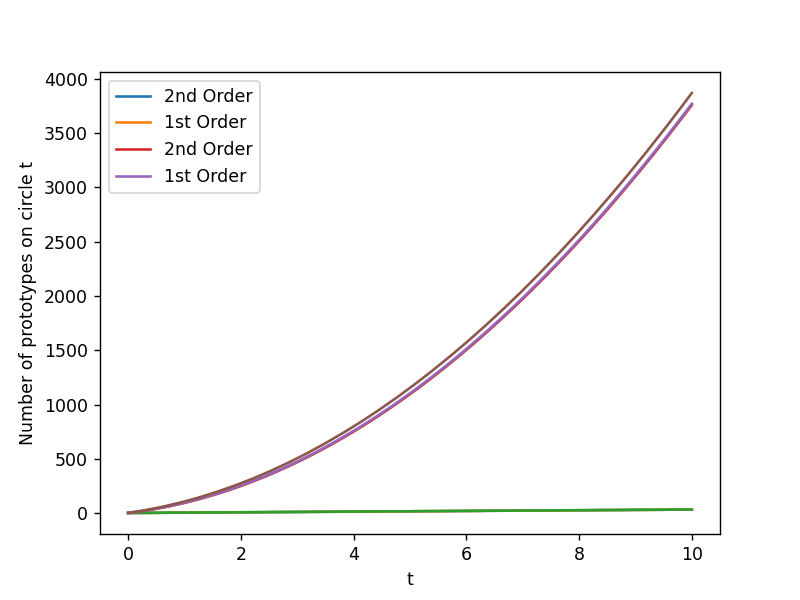

In [47]:
def second_order(t):
    return np.sqrt(((t+1)**2)*(np.pi**2)/2 +(t+1)*np.sqrt(((t+1)**2)*(np.pi**4)/4 - (t+((t+1)*(np.pi**2)/12))*((np.pi**2)/(t+1))))
def first_order(t):
    return (t+1)*np.pi

interval = np.linspace(0,10,200)
plt.plot(interval,second_order(interval),label="2nd Order")
plt.plot(interval,first_order(interval), label = "1st Order")
plt.plot(interval,np.ceil(first_order(interval)))
#plt.ylim(0,15)
plt.legend()
plt.ylabel("Number of prototypes on circle t")
plt.xlabel("t")
#plt.savefig("seriesapprox.png")
plt.show()


<IPython.core.display.Javascript object>


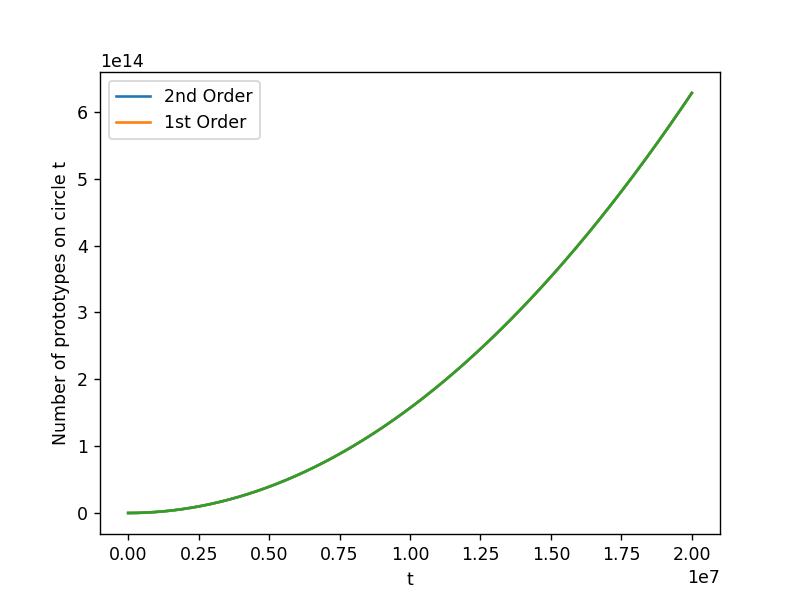

In [108]:
interval = np.linspace(0,19999999,20000000)
plt.plot(interval,np.cumsum(second_order(interval)),label="2nd Order")
plt.plot(interval,np.cumsum(first_order(interval)), label = "1st Order")
plt.plot(interval,np.cumsum(np.ceil(first_order(interval))))
#plt.ylim(0,15)
plt.legend()
plt.ylabel("Number of prototypes on circle t")
plt.xlabel("t")
#plt.savefig("seriesapprox.png")
plt.show()


In [110]:
np.cumsum(np.ceil(first_order(interval))) - (0.999999*(interval+1)+((interval+1)*(interval+2)*np.pi))/2

array([ 0.35840785,  0.57522304,  0.65044558, ..., -7.125     ,
       -7.625     , -7.125     ])

In [85]:
interval*(interval+1)*np.pi/2

array([0.00000000e+00, 3.14159265e+00, 9.42477796e+00, ...,
       6.26748677e+06, 6.27376367e+06, 6.28004371e+06])